In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import pytorch_lightning as pl

import torch
from torch import optim

from bliss.models import encoder, decoder, flux_net
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import plotting_utils 

device = "cuda:4"
print(device)

pl.seed_everything(2323)

Global seed set to 2323


cuda:4


2323

# Load dataset

In [2]:
overrides = {'model':"sleep_sdss_detection", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
cfg.model.kwargs.decoder_kwargs.update({# 'prob_galaxy': 0., 
                                        'f_min': 1e3,
                                        'f_max': 1e5})

In [4]:
cfg.optimizer.kwargs.update({'lr': 0.001})

cfg.dataset.kwargs.update({'batch_size': 128})

In [5]:
# set device
cfg.dataset.kwargs.update({'generate_device': device})

In [6]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

In [7]:
cfg.training.n_epochs

121

### some sample images

In [8]:
test_dataloader = dataset.test_dataloader()

In [9]:
for _, batch in enumerate(test_dataloader):
    break

In [10]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [11]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * dataset.image_decoder.slen + \
                dataset.image_decoder.border_padding - 0.5
    
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [12]:
%matplotlib inline

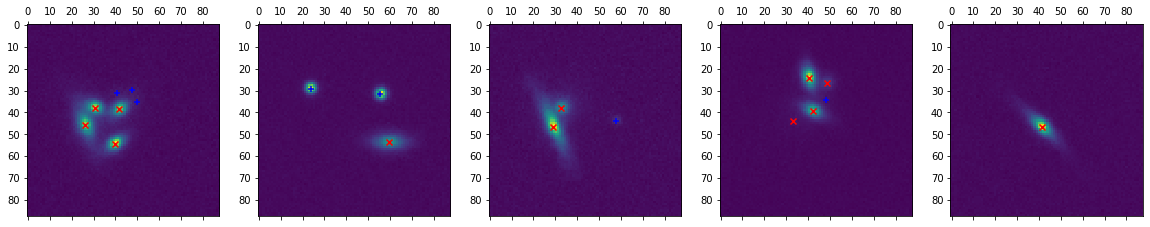

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for indx in range(batch['images'].shape[0]):
    
    if indx > 4: 
        break
        
    # plot image 
    axes[indx].matshow(batch['images'][indx, 0].cpu())

    # plot parameters
    plot_params(true_params, indx, axes[indx])

(array([91.,  8.,  3.,  2.,  1.,  0.,  2.,  0.,  4.,  2.]),
 array([ 1011.62634, 10780.7705 , 20549.916  , 30319.059  , 40088.203  ,
        49857.348  , 59626.492  , 69395.64   , 79164.78   , 88933.93   ,
        98703.07   ], dtype=float32),
 <BarContainer object of 10 artists>)

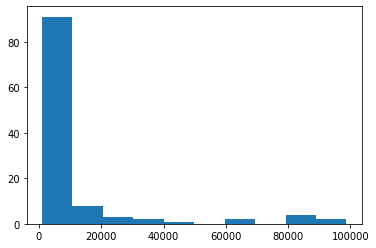

In [14]:
f = batch['fluxes'].flatten()
f = f[f > 0]

plt.hist(f.cpu().numpy())

# Define encoder

In [15]:
warm_start = False

In [16]:
if warm_start: 
    flux_checkpoint_file = '/home/runingli/astronomy/celeste/models/flux_net_single_tile.ckpt'
    flux_estimator = flux_net.FluxEstimator.load_from_checkpoint(flux_checkpoint_file, 
                                                               decoder_kwargs = cfg.model.kwargs.decoder_kwargs)
    flux_estimator.to(device);
else: 
    flux_estimator = flux_net.FluxEstimator(cfg.model.kwargs.decoder_kwargs, 
                                        optimizer_params=cfg.optimizer)
    flux_estimator.to(device);

conv_out_dim 16


### Initial loss

In [17]:
def eval_loss(): 
    loss = 0
    counter = 0
    target = 0

    for _, batch in enumerate(test_dataloader):
        
        # estimated loss
        loss += flux_estimator.get_loss(batch)

        # loss under the truth
        target += flux_estimator.kl_qp_flux_loss( 
                        batch,
                        batch['fluxes'], 
                        # set the sd to 1
                        batch['fluxes'] * 0. + 1.0)[0].sum()
        
        break

    print('loss:   {}'.format(loss))
    print('target: {}'.format(target))

In [18]:
eval_loss()

loss:   46740.8984375
target: 37307.5859375


# Optimize

In [19]:
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [20]:
t0 = time.time()
trainer.fit(flux_estimator, datamodule = dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type           | Params
-------------------------------------------------
0 | image_decoder | ImageDecoder   | 54.6 K
1 | enc           | FluxEncoderNet | 12.8 K
-------------------------------------------------
12.8 K    Trainable params
54.6 K    Non-trainable params
67.4 K    Total params
0.270     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 2323


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluate

In [21]:
flux_estimator.to(device);

In [22]:
for _, test_batch in enumerate(test_dataloader):
    break

In [23]:
# get estimates
out = flux_estimator(test_batch['images'])

# get loss
_, recon = flux_estimator.kl_qp_flux_loss(test_batch,
                                             out['mean'], 
                                             out['sd'])

In [24]:
_true_tile_dict = dict(locs = test_batch['locs'],
                       n_sources = test_batch['n_sources'],
                       galaxy_bool = test_batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


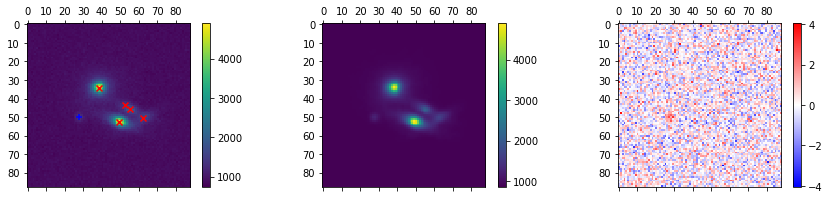

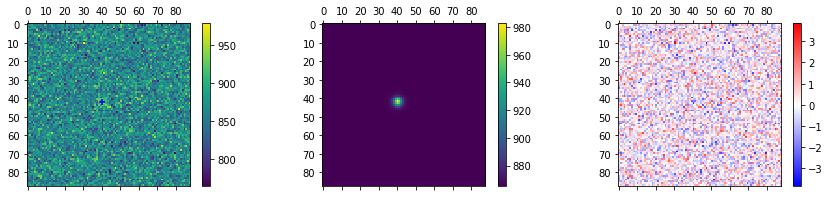

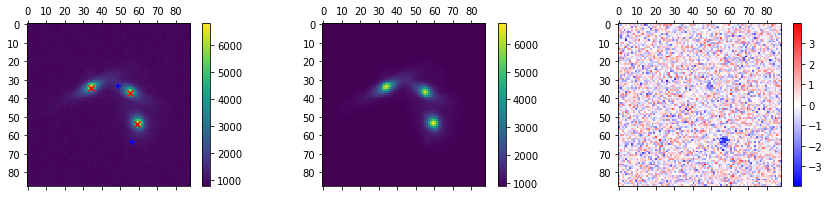

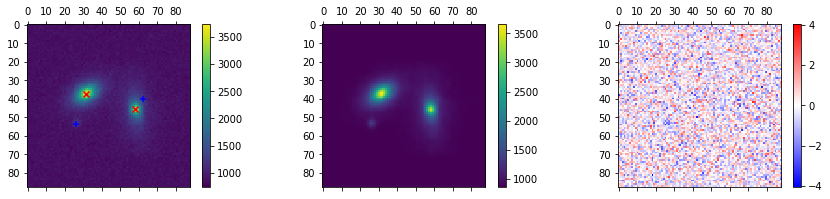

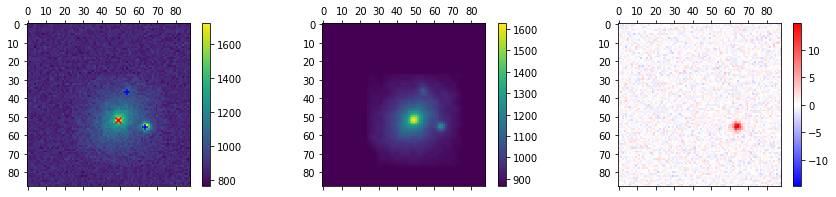

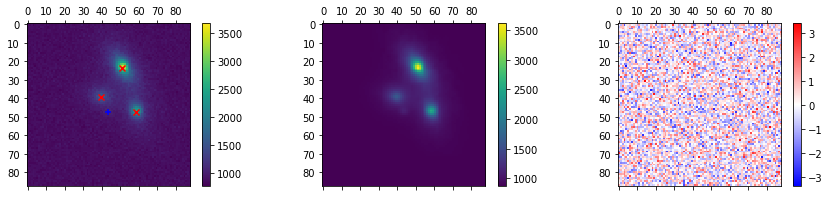

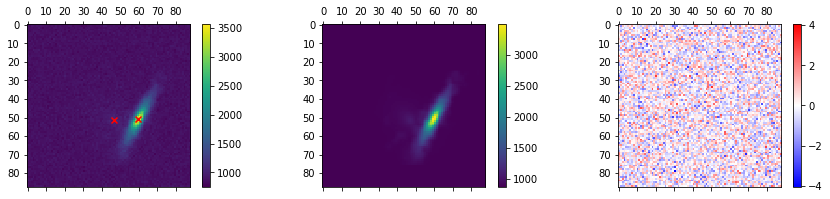

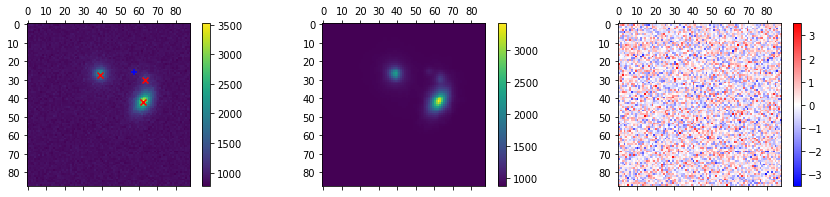

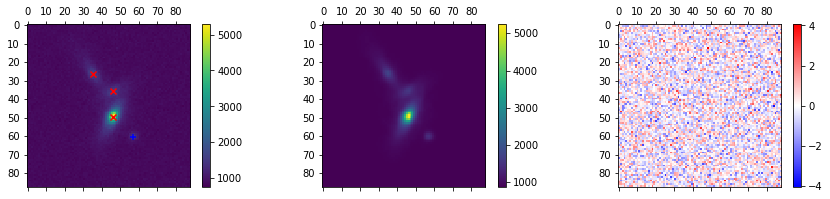

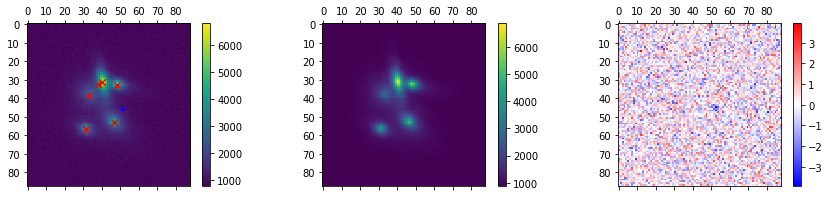

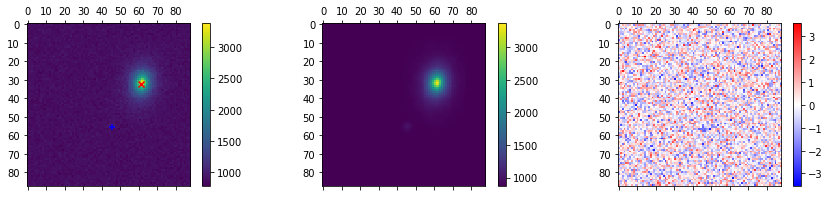

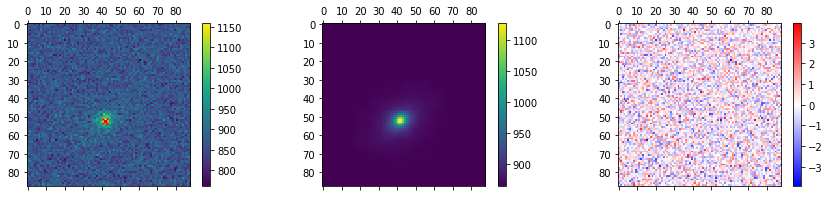

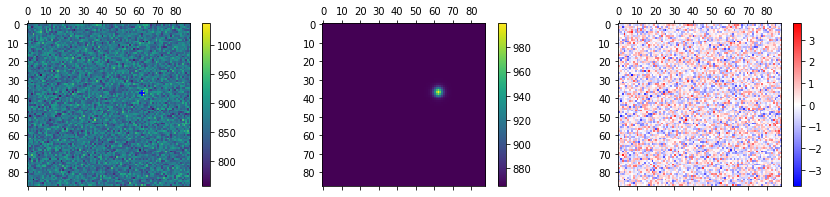

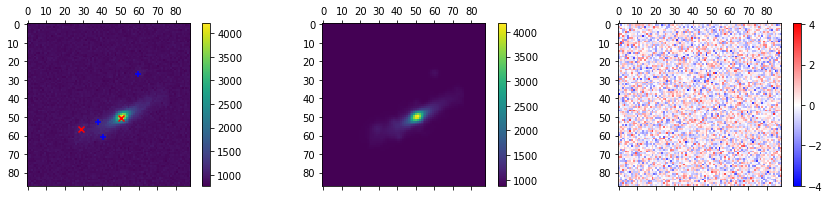

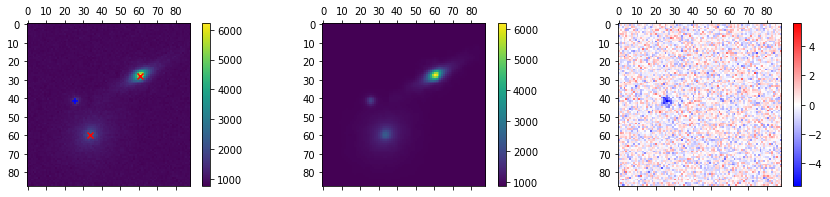

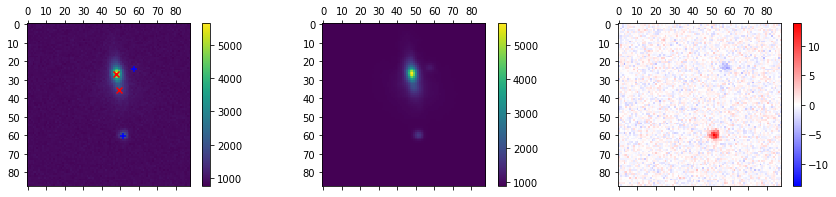

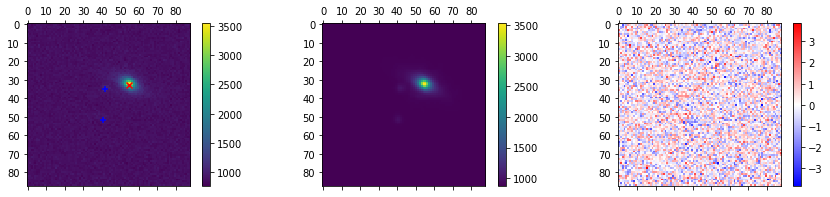

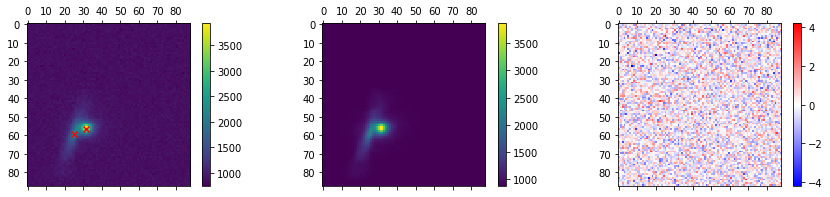

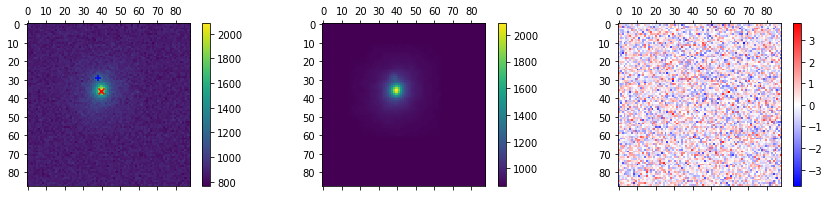

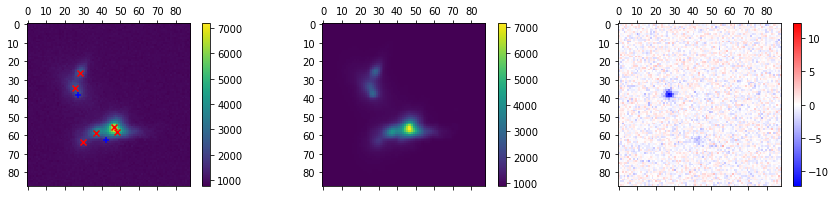

In [25]:
for indx in range(20):

    fig, ax = plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                            recon[indx, 0], 
                                            resid_fun=lambda x, y : (x - y) / torch.sqrt(y))
    
    # plot parameters
    plot_params(true_params, indx, ax[0])

### Compare fluxes

In [26]:
truth = []
est = []
sd = []

for _, batch in enumerate(test_dataloader):
    
    # get estimates
    out = flux_estimator(batch['images'])
    
    is_star = get_star_bool(batch['n_sources'], batch['galaxy_bool']) == 1

    _truth = batch['fluxes'][is_star].cpu().numpy()
    _est = out['mean'][is_star].cpu().detach().numpy()
    _sd = out['sd'][is_star].cpu().detach().numpy()
    
    truth.append(_truth)
    est.append(_est)
    sd.append(_sd)
    
truth = np.concatenate(truth)
est = np.concatenate(est)
sd = np.concatenate(sd)

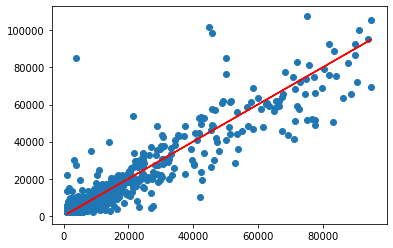

In [27]:
plt.scatter(truth, est)

plt.plot(truth, truth, color = 'red')

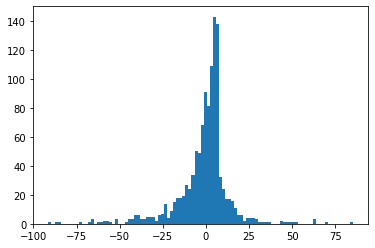

In [28]:
zscore = (est - truth) / sd

plt.hist(zscore, bins = 100);

(array([866., 130.,  53.,  30.,  22.,  20.,   9.,   8.,   3.,   5.]),
 array([ 155.27002,  260.5819 ,  365.89383,  471.20572,  576.51764,
         681.8295 ,  787.1414 ,  892.4533 ,  997.76526, 1103.0771 ,
        1208.389  ], dtype=float32),
 <BarContainer object of 10 artists>)

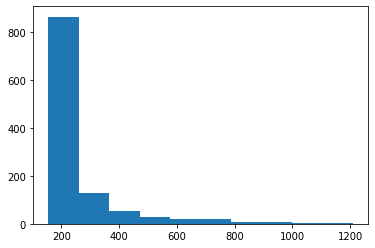

In [29]:
plt.hist(sd)

In [31]:
trainer.save_checkpoint('../../models/flux_net.ckpt')